Scania_Failures  Mediante Logistic Regression
Codigo E.Parodi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
df_train = pd.read_csv('Data Set/aps_failure_training_set.csv',na_values='na')
df_test = pd.read_csv('Data Set/aps_failure_test_set.csv', na_values='na')

In [3]:
feature_columns = df_train.drop(columns=['class']).columns.values
df_train[feature_columns]=df_train[feature_columns].fillna(df_train.mean())
df_test[feature_columns]=df_test[feature_columns].fillna(df_test.mean())

In [4]:
df_train['target'] = df_train['class'].replace ({'neg':-1, 'pos':1})
df_test['target'] = df_test['class'].replace ({'neg':-1, 'pos':1})
print( 'df_train target:'), print(df_train['target'].value_counts())

df_train target:
-1    59000
 1     1000
Name: target, dtype: int64


(None, None)

In [5]:
from sklearn.model_selection import train_test_split
X = df_train[feature_columns]
y = df_train['target']
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.1)

In [6]:
# Costo de Chequeo innecesario = 10
# Costo de Perder un chequeo por falla = 500
# El costo promedio de pronosticar todos los valores como negativos (0) sería de: 500 x 1,000/60,000 = 8.33 (Gondek et all)
# El costo promedio de pronosticar todos los valores como positivos (1) sería de: 10 x 59,000/60,000 = 9.83 (Gondek et all)


In [177]:
from sklearn.linear_model import LogisticRegression
modelo = LogisticRegression(C=1, class_weight={-1:1, 1:59})
modelo.fit(X_train, y_train)

LogisticRegression(C=1, class_weight={-1: 1, 1: 59}, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [201]:
probabilidades_val = modelo.predict_proba(X_val)
predicciones_val = np.where(probabilidades_val[:,1] > 0.37, +1, -1) 

In [202]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

matriz_confusion = metrics.confusion_matrix(y_val, predicciones_val)
predecido = predicciones_val

TN = matriz_confusion[0,0]
FN = matriz_confusion[1,0]
FP = matriz_confusion[0,1]
TP = matriz_confusion[1,1]

accuracy_val = metrics.accuracy_score(y_val, predecido)
precision_val = metrics.precision_score (y_val, predecido)
recall_val = metrics.recall_score (y_val, predecido)

print(matriz_confusion)

print('Exactitud en el conjunto de validación     : {:.3f}'.format(accuracy_val))
print('Precisión en el conjunto de validación     : {:.3f}'.format(precision_val))
print('Exhaustividad en el conjunto de validación : {:.3f}'.format(recall_val))
print('Costo promedio:', (FP*10+FN*500)/6000)

[[5680  211]
 [   6  103]]
Exactitud en el conjunto de validación     : 0.964
Precisión en el conjunto de validación     : 0.328
Exhaustividad en el conjunto de validación : 0.945
Costo promedio: 0.8516666666666667


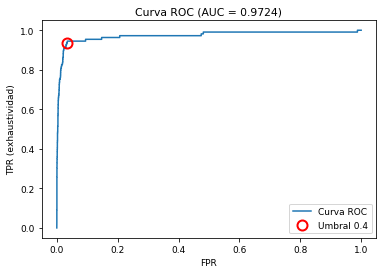

In [195]:
# Código de ejemplo de clase
fpr, tpr, umbrales = metrics.roc_curve(y_val, probabilidades_val[:,1])
auc_roc = metrics.roc_auc_score(y_val, probabilidades_val[:,1])

plt.rcParams.update({'font.size': 9})
plt.plot(fpr, tpr, label= ("Curva ROC") )
plt.xlabel("FPR")
plt.ylabel("TPR (exhaustividad)")
plt.title(("Curva ROC (AUC = %.4f)" % auc_roc))

# ubicamos el punto más cercano a 0.5
umbral_04 = np.argmin(np.abs(umbrales - 0.4))
plt.plot(fpr[umbral_04], tpr[umbral_04], 'o', markersize=10,
         label="Umbral 0.4", fillstyle="none", c='r', mew=2)
plt.legend(loc='best', numpoints = 1)

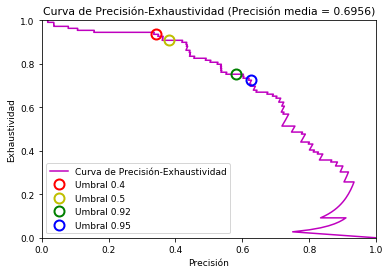

In [196]:
precision, exhaustividad, umbrales = metrics.precision_recall_curve(y_val, probabilidades_val[:,1])
precision_media = metrics.average_precision_score(y_val, probabilidades_val[:,1])

plt.plot(precision, exhaustividad, label= ("Curva de Precisión-Exhaustividad"), c='m' )
plt.xlabel("Precisión")
plt.ylabel("Exhaustividad")
plt.title(("Curva de Precisión-Exhaustividad (Precisión media = %.4f)" % precision_media))

umbral_04 = np.argmin(np.abs(umbrales - 0.4))
plt.plot(precision[umbral_04], exhaustividad[umbral_04], 'o', markersize=10,
         label="Umbral 0.4", fillstyle="none", c='r', mew=2)

umbral_05 = np.argmin(np.abs(umbrales - 0.5))
plt.plot(precision[umbral_05], exhaustividad[umbral_05], 'o', markersize=10,
         label="Umbral 0.5", fillstyle="none", c='y', mew=2)

umbral_092 = np.argmin(np.abs(umbrales - 0.92))
plt.plot(precision[umbral_092], exhaustividad[umbral_092], 'o', markersize=10,
         label="Umbral 0.92", fillstyle="none", c='g', mew=2)

umbral_095 = np.argmin(np.abs(umbrales - 0.95))
plt.plot(precision[umbral_095], exhaustividad[umbral_095], 'o', markersize=10,
         label="Umbral 0.95", fillstyle="none", c='b', mew=2)

plt.gca().set_xlim([0,1])
plt.gca().set_ylim([0,1])
plt.legend(loc='best', numpoints = 1)

In [197]:
umbrales_precision_exhaustividad = pd.DataFrame({ 
        'Exhaustividad' : exhaustividad,
        'Precisión' : precision,
        'Umbrales' : np.append(umbrales, 1) # El último umbral es siempre 1
    })

umbrales_precision_exhaustividad[umbrales_precision_exhaustividad['Precisión'] >= .30].head()

,Exhaustividad,Precisión,Umbrales
5585,0.944954,0.300292,0.299763
5586,0.944954,0.301170,0.301249
5587,0.944954,0.302053,0.301312
5588,0.944954,0.302941,0.302431
5589,0.944954,0.303835,0.307911


In [198]:
X_test = df_test[feature_columns]
y_test = df_test['target']

In [203]:
probabilidades_test = modelo.predict_proba(X_test)
predicciones_test = np.where(probabilidades_test[:,1] > 0.37, +1, -1) 

In [205]:
matriz_confusion = metrics.confusion_matrix(y_test, predicciones_test)
predecido = predicciones_test

accuracy_test = metrics.accuracy_score(y_test, predecido)
precision_test = metrics.precision_score (y_test, predecido)
recall_test = metrics.recall_score (y_test, predecido)

TN = matriz_confusion[0,0]
FN = matriz_confusion[1,0]
FP = matriz_confusion[0,1]
TP = matriz_confusion[1,1]

print(matriz_confusion)

print('Exactitud en el conjunto de prueba     : {:.3f}'.format(accuracy_test))
print('Precisión en el conjunto de prueba     : {:.3f}'.format(precision_test))
print('Exhaustividad en el conjunto de prueba : {:.3f}'.format(recall_test))
print(TN,FN,FP,TP)
print('Costo promedio:', (FP*10+FN*500)/6000)
print('Costo total:', (FP*10+FN*500))

[[15221   404]
 [   27   348]]
Exactitud en el conjunto de prueba     : 0.973
Precisión en el conjunto de prueba     : 0.463
Exhaustividad en el conjunto de prueba : 0.928
15221 27 404 348
Costo promedio: 2.9233333333333333
Costo total: 17540


In [ ]:
#Para un Umbral de 0.37 y C=1 , se logran los menores costos para el conjunto de validación que es de 0.84 promedio
# sin embargo, esto no se refleja en el conjunto de prueba cuyo costo promedio es de 2.92, por lo que estimo que el
#resultado podría mejorarse hasta un costo total de 6000 aprox.
